In [2]:
# Import dependencies
# spotipy is a library with methods that call the Spotify API

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from config import client_id, secret, api_key

In [3]:
# Establish connection to Spotify

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [67]:
# Create empty lists to store data from API calls

artist_name = []
track_name = []
track_id = []
popularity = []
artist_id = []

# Run a for loop to call the API multiple times for a list of tracks
# Starter code from a similar project:
# https://tgel0.github.io/blog/spotify-data-project-part-1-from-data-retrieval-to-first-insights/

# i represents each call of the Spotify search API, range is maximum results, step 50 represents 50 results per search
for i in range(0,1000,50):
    
    # Save results of each search as a variable. Limit search to 50 results, use offset to skip previous result of iteration
    track_results = sp.search(q='year:2019', type='track', limit=50,offset=i)
    
    # Loop through each result to find values for selected fields
    # Enumerate creates a tuple of each track result for iteration. Example: (0, J. Cole), (1, Ariana Grande), etc.
    for i, t in enumerate(track_results['tracks']['items']):
        artist_id.append(t['artists'][0]['id'])
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])

In [69]:
# Create empty list for genre of each artist
genres = []

# Loop through artist id list, calling API for each artist id
for artist in range(0,1000):
    
    # sp.artist calls Spotify API using spotipy library to find artist
    artist_results = sp.artist(artist_id[artist])
    
    # Append list of genres from results to genres list
    genres.append(artist_results["genres"])

In [70]:
# Create empty lists to store audio feature values
danceability = []
energy = []
loudness = []
valence = []
tempo = []

# Loop through track id list to find audio features for each track
for track in range(0,1000):
    
    # Append selected values to corresponding lists
    try:
        audio_features = sp.audio_features(track_id[track])
        danceability.append(audio_features[0]["danceability"])
        energy.append(audio_features[0]["energy"])
        loudness.append(audio_features[0]["loudness"])
        valence.append(audio_features[0]["valence"])
        tempo.append(audio_features[0]["tempo"])
    
    # Error results if there are no features available. Use try/except to set value to 0 when there is an error
    except TypeError:
        danceability.append(0)
        energy.append(0)
        loudness.append(0)
        valence.append(0)
        tempo.append(0)

In [71]:
# Create datarframe from lists populated by loops
features_df = pd.DataFrame({"Track ID": track_id, "Artist Name": artist_name, "Track Name":track_name,
                            "Danceability":danceability, "Energy":energy, "Loudness":loudness,
                            "Valence":valence, "Tempo": tempo, "Popularity": popularity})

# Sort by Popularity score in descending order
features_df = features_df.sort_values(by=["Popularity"], ascending=False)

# Save to csv
features_df.to_csv("audio_features.csv", index=False)
features_df.head()

,Track ID,Artist Name,Track Name,Danceability,Energy,Loudness,Valence,Tempo,Popularity
29,5w9c2J52mkdntKOmRLeM2m,Daddy Yankee,Con Calma,0.737,0.860,-2.652,0.656,93.989,100
2,2Fxmhks0bxGSBdJ92vM42m,Billie Eilish,bad guy,0.708,0.418,-10.998,0.578,131.926,98
3,4y3OI86AEP6PQoDE6olYhO,Jonas Brothers,Sucker,0.842,0.734,-5.065,0.952,137.958,98
4,4kV4N9D1iKVxx1KLvtTpjS,Ariana Grande,"break up with your girlfriend, i'm bored",0.726,0.554,-5.290,0.335,169.999,98
11,6Qs4SXO9dwPj5GKvVOv8Ki,Sam Smith,Dancing With A Stranger (with Normani),0.741,0.520,-7.513,0.347,102.998,96


In [72]:
# To remove tracks that have no audio features:

# Cast dataframe as list and remove columns that do not show audio feature values
col_list= list(features_df)
col_list.remove("Track ID")
col_list.remove("Artist Name")
col_list.remove("Track Name")
col_list.remove("Popularity")

# Use .loc to filter. Tracks with no audio features available were set to 0, so sum will be 0.
# This filters out tracks with no features available, but leaves in those that may have 0 for a certain value.
features_df.loc[features_df[col_list].sum(axis=1) > 0]
features_df.head()

,Track ID,Artist Name,Track Name,Danceability,Energy,Loudness,Valence,Tempo,Popularity
29,5w9c2J52mkdntKOmRLeM2m,Daddy Yankee,Con Calma,0.737,0.860,-2.652,0.656,93.989,100
2,2Fxmhks0bxGSBdJ92vM42m,Billie Eilish,bad guy,0.708,0.418,-10.998,0.578,131.926,98
3,4y3OI86AEP6PQoDE6olYhO,Jonas Brothers,Sucker,0.842,0.734,-5.065,0.952,137.958,98
4,4kV4N9D1iKVxx1KLvtTpjS,Ariana Grande,"break up with your girlfriend, i'm bored",0.726,0.554,-5.290,0.335,169.999,98
11,6Qs4SXO9dwPj5GKvVOv8Ki,Sam Smith,Dancing With A Stranger (with Normani),0.741,0.520,-7.513,0.347,102.998,96


In [76]:
# Genres in artist results were stored in a list because artists can be classified to more than one genre
# Individual genres must be split to determine average popularity

# Create empty list for individuals genres split from lists
split_genres = []

# Splitting genres will result in multiple entries for each artist, track, and popularity score
# Must create empty lists to store split artists, tracks, and popularity
split_artists = []
split_track = []
split_popularity = []

# Loop through list of genre lists
for x in range(len(genres)):
    
    # Nested loop to append artist names, tracks, and popularity
    for y in genres[x]:
        split_genres.append(y)
        split_artists.append(artist_name[x])
        split_track.append(track_name[x])
        split_popularity.append(popularity[x]) 

In [77]:
# Create Dataframe for split genres
split_df = pd.DataFrame({"Artist Name": split_artists, "Track Name": split_track,
                         "Genre": split_genres, "Popularity Score": split_popularity})

# Remove genres with Popularity of 0
split_df = split_df.loc[split_df["Popularity Score"] >= 1]

# Save to csv
split_df.to_csv("split_genre.csv", index=False)
split_df.head()

,Artist Name,Track Name,Genre,Popularity Score
0,J. Cole,MIDDLE CHILD,conscious hip hop,95
1,J. Cole,MIDDLE CHILD,nc hip hop,95
2,J. Cole,MIDDLE CHILD,pop rap,95
3,J. Cole,MIDDLE CHILD,rap,95
4,Billie Eilish,bad guy,electropop,98


In [78]:
# Group by genre and visualize with .mean() to get average popularity
avg_pop_df = split_df.groupby("Genre").mean()

# Group by genre and visualize with .count() to find total occurences of each genre
count_pop_df = split_df.groupby("Genre").count()

# Drop non-numerical columns
count_pop_df = count_pop_df.drop(columns=["Artist Name", "Track Name"])

# Sort by Popularity in descending order and include only the top 20
count_pop_df = count_pop_df.sort_values(by=["Popularity Score"], ascending=False).nlargest(20, "Popularity Score")
count_pop_df.head(20)

,Popularity Score
Genre,
pop,426
rap,224
trap music,205
dance pop,199
pop rap,194
post-teen pop,120
southern hip hop,113
hip hop,105
atl hip hop,83


In [79]:
# Merge avg and count Dataframes to show occurences of each genre and average popularity
genre_popularity_df = pd.merge(count_pop_df, avg_pop_df, on="Genre", how="left")

# Rename columns to specify which column corresponds to each measurement
genre_popularity_df = genre_popularity_df.rename(columns={"Popularity Score_x": "Genre Count",
                                                       "Popularity Score_y": "Average Popularity Score"})

# Sort by Average score in descending order
genre_popularity_df = genre_popularity_df.sort_values(by="Average Popularity Score")
genre_popularity_df.head(20)

,Genre Count,Average Popularity Score
Genre,,
contemporary country,68,63.852941
r&b,74,64.175676
dance pop,199,65.070352
folk-pop,45,65.177778
country road,47,65.574468
modern rock,45,67.822222
pop rap,194,68.355670
pop,426,68.363850
post-teen pop,120,68.450000


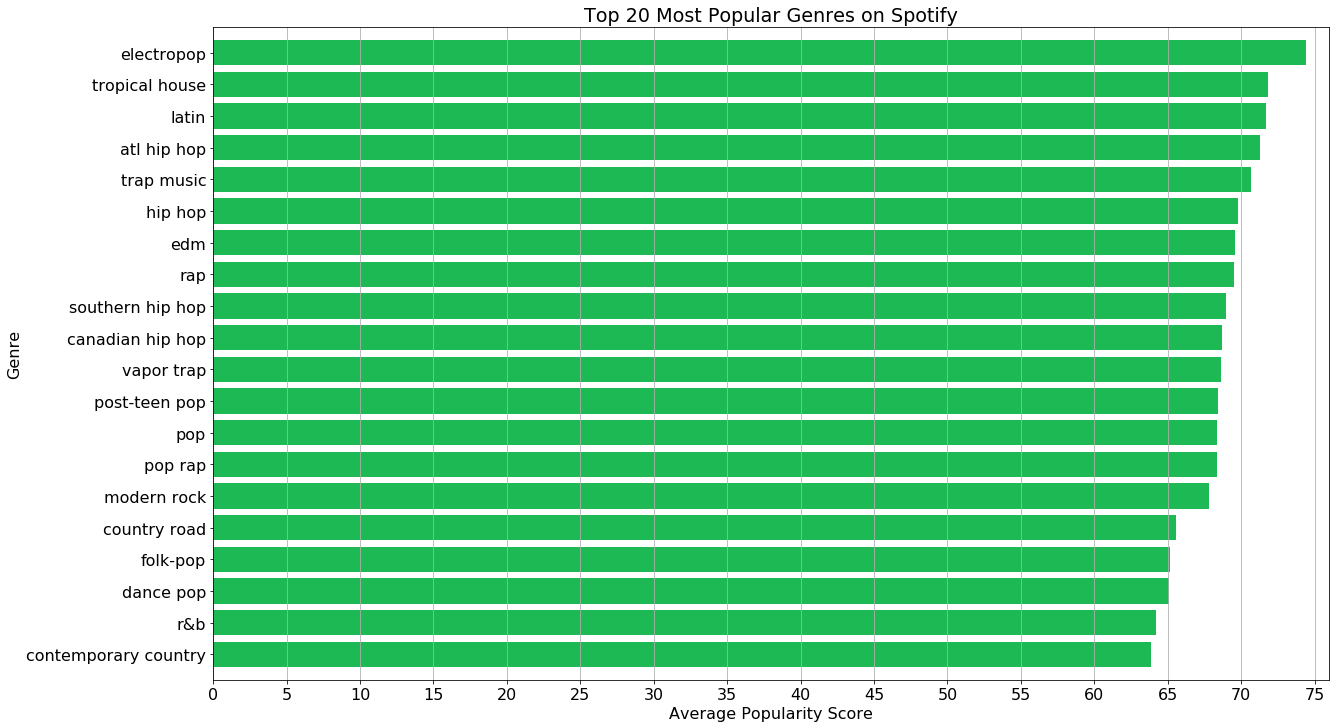

In [118]:
# Set range for barh y axis
y = np.arange(0, len(genre_popularity_df))

# Assign ticks for y axis
ticks = genre_popularity_df.index

# Set width of bar for each genre to it's average popularity
width = genre_popularity_df["Average Popularity Score"]

# Create horizontal bar plot, setting bars to color of the Spotify logo
genre_plot = plt.barh(y, width, color="#1DB954")

# Set values and labels for y ticks
plt.yticks(ticks=y, labels=ticks)

# Set range and interval for x ticks
plt.xticks(ticks=np.arange(0, genre_popularity_df["Average Popularity Score"].max()+1, 5))

# Apply ticks to y axis
plt.tick_params(axis="y")

# Set x and y limits
plt.ylim(-0.8, 19.8)
plt.xlim(0, 76)

# Change figsize
plt.rcParams["figure.figsize"] = (20,12)

# Add title and axis labels
plt.title("Top 20 Most Popular Genres on Spotify")
plt.xlabel("Average Popularity Score")
plt.ylabel("Genre")

# Add vertical gridlines
plt.grid(axis="x")

# Increase font size
plt.rcParams.update({'font.size': 16})

# Save as png
plt.savefig("top-20_genres.png")
plt.show()

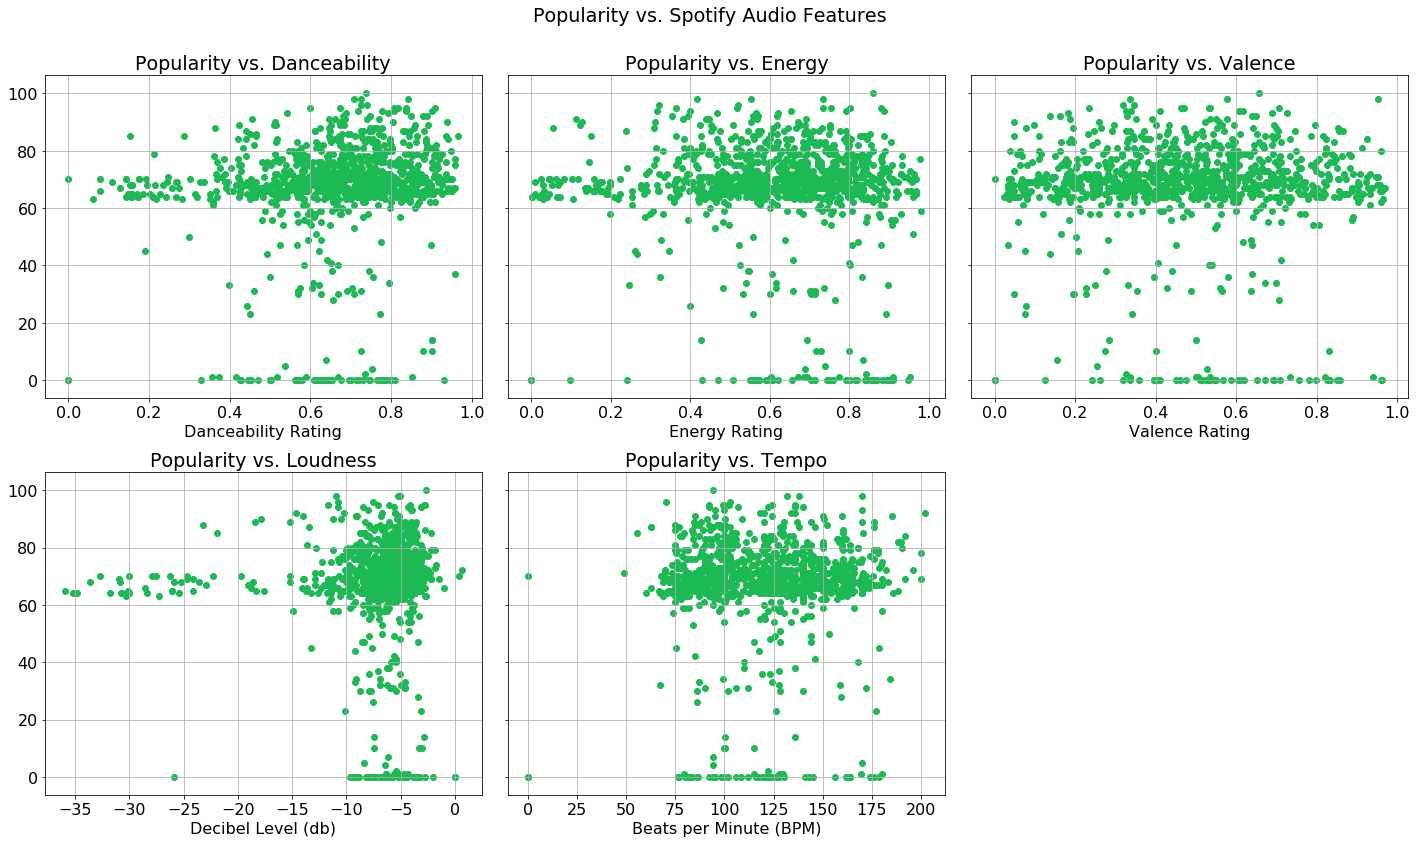

In [106]:
# Use subplots to arrange plots for audio features into two rows of three columns with shared y axis
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharey=True)

# Only measuring five features, but we cannot set an odd number of subplots, so we delete ax6
fig.delaxes(ax6)

# Set x values for each plot and y value shared by all plots
dance_x = features_df["Danceability"]
energy_x = features_df["Energy"]
loudness_x = features_df["Loudness"]
valence_x = features_df["Valence"]
tempo_x = features_df["Tempo"]
y = features_df["Popularity"]

# Create danceability plot
ax1.scatter(dance_x, y, color="#1DB954")
ax1.set_title("Popularity vs. Danceability")
ax1.set_xlabel("Danceability Rating")
ax1.grid()

# Create energy plot
ax2.scatter(energy_x, y, color="#1DB954")
ax2.set_title("Popularity vs. Energy")
ax2.set_xlabel("Energy Rating")
ax2.grid()

# Create valence plot
ax3.scatter(valence_x, y, color="#1DB954")
ax3.set_title("Popularity vs. Valence")
ax3.set_xlabel("Valence Rating")
ax3.grid()

# Create loudness plot
ax4.scatter(loudness_x, y, color="#1DB954")
ax4.set_title("Popularity vs. Loudness")
ax4.set_xlabel("Decibel Level (db)")
ax4.grid()

# Create tempo plot
ax5.scatter(tempo_x, y, color="#1DB954")
ax5.set_title("Popularity vs. Tempo")
ax5.set_xlabel("Beats per Minute (BPM)")
ax5.grid()

# Change figsize and font size for all plots
plt.rcParams["figure.figsize"] = (20,12)
plt.rcParams.update({'font.size': 16})

# Use tight layout to reduce overlap between labels for each plot
plt.tight_layout()

# Add master title for all plots
fig.suptitle("Popularity vs. Spotify Audio Features")

# Adjust suptitle so it does not overlap with top row titles
plt.subplots_adjust(top=0.90)
plt.show()

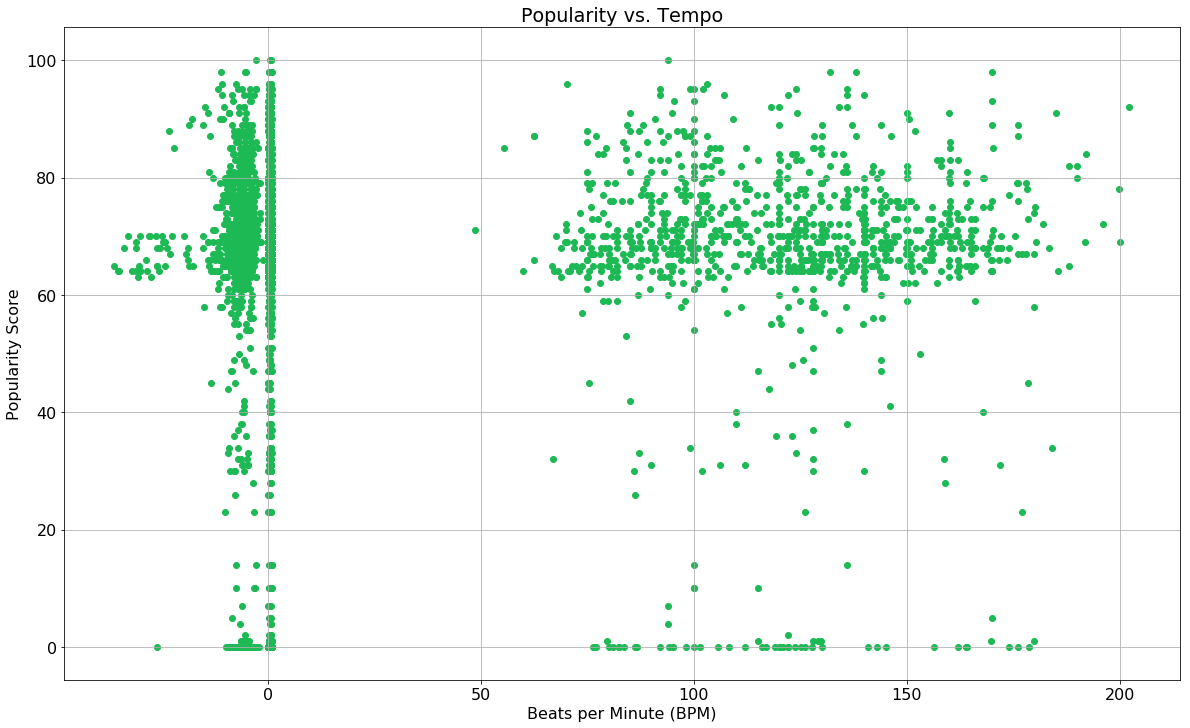

In [114]:
# Need to save individual plots for website, so each plot must be re-entered individually
plt.scatter(dance_x, y, color="#1DB954")
plt.title("Popularity vs. Danceability")
plt.xlabel("Danceability Rating")
plt.ylabel("Popularity Score")
plt.grid()
plt.rcParams["figure.figsize"] = (20,12)
plt.rcParams.update({'font.size': 16})
plt.savefig("danceability.png")

plt.scatter(energy_x, y, color="#1DB954")
plt.title("Popularity vs. Energy")
plt.xlabel("Energy Rating")
plt.ylabel("Popularity Score")
plt.grid()
plt.rcParams["figure.figsize"] = (20,12)
plt.rcParams.update({'font.size': 16})
plt.savefig("energy.png")

plt.scatter(valence_x, y, color="#1DB954")
plt.title("Popularity vs. Valence")
plt.xlabel("Valence Rating")
plt.ylabel("Popularity Score")
plt.grid()
plt.rcParams["figure.figsize"] = (20,12)
plt.rcParams.update({'font.size': 16})
plt.savefig("valence.png")

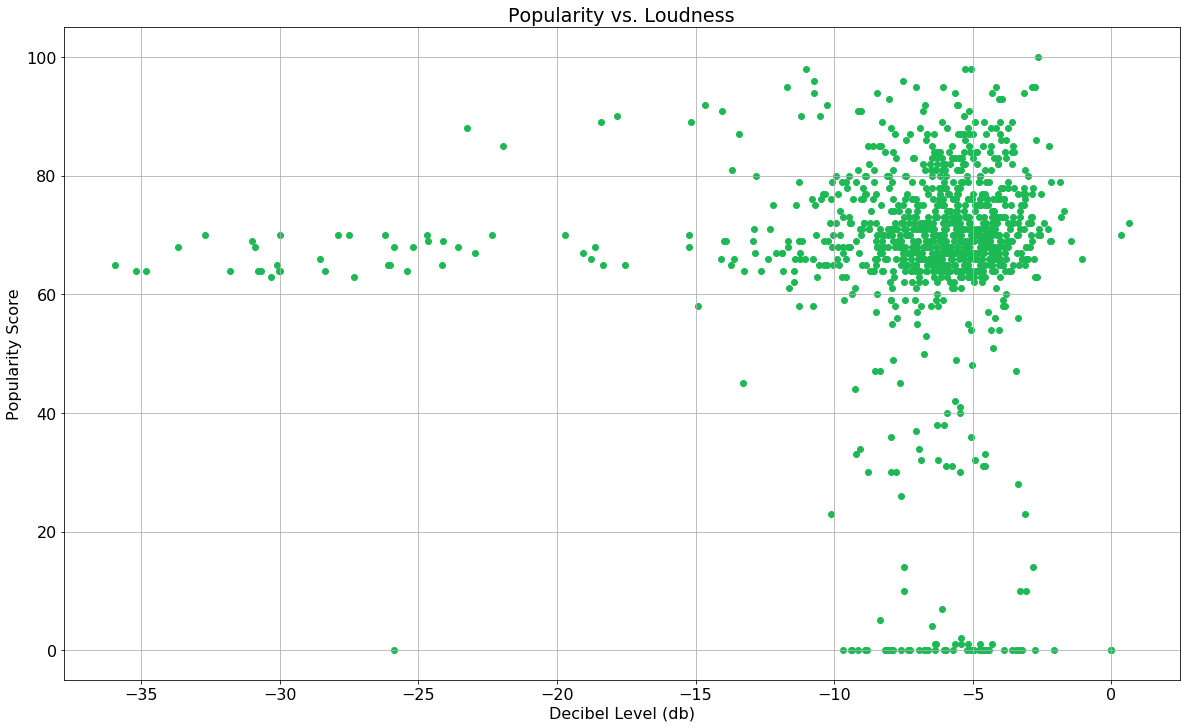

In [115]:
plt.scatter(loudness_x, y, color="#1DB954")
plt.title("Popularity vs. Loudness")
plt.xlabel("Decibel Level (db)")
plt.ylabel("Popularity Score")
plt.grid()
plt.rcParams["figure.figsize"] = (20,12)
plt.rcParams.update({'font.size': 16})
plt.savefig("loudness.png")

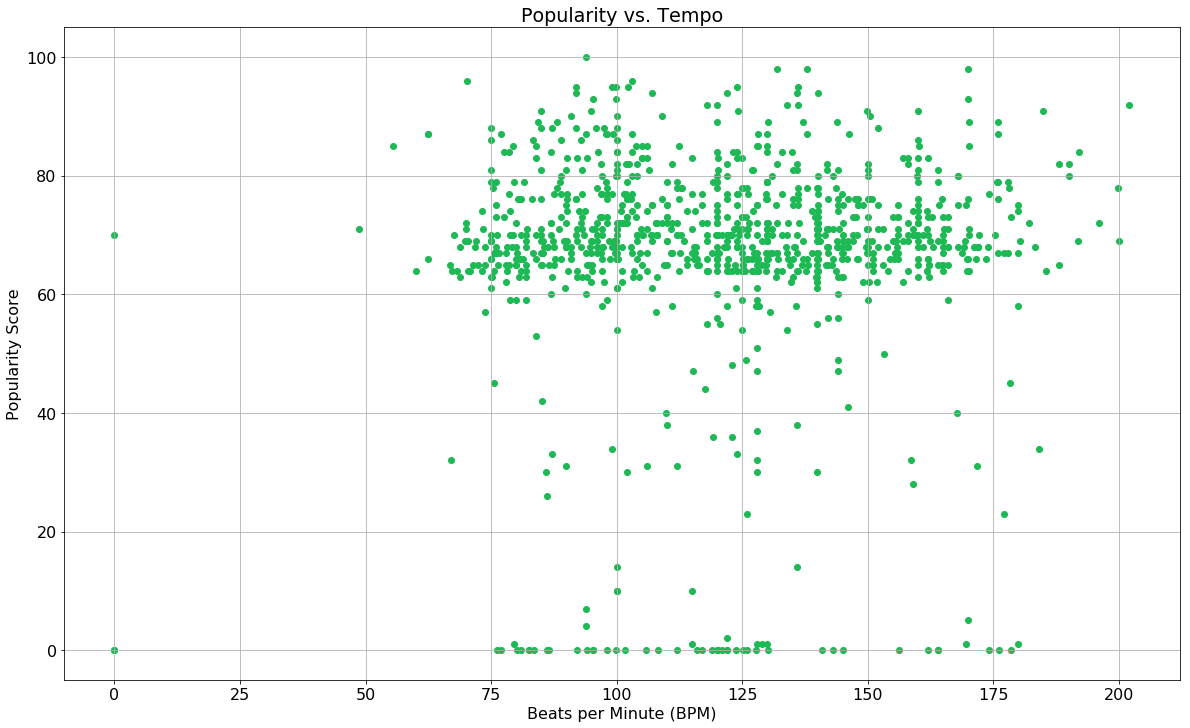

In [117]:
plt.scatter(tempo_x, y, color="#1DB954")
plt.title("Popularity vs. Tempo")
plt.xlabel("Beats per Minute (BPM)")
plt.ylabel("Popularity Score")
plt.grid()
plt.rcParams["figure.figsize"] = (20,12)
plt.rcParams.update({'font.size': 16})
plt.savefig("tempo.png")